# Проект: Система поиска подходящих товаров на основе дообученной CLIP модели


## Постановка задачи

Нужно реализовать такую систему: пользователь описывает вещь словами, система находит и показывает наиболее близкие позиции из базы. Компания выходит на международный рынок, поэтому система будет работать на английском языке.

Нужно:
- дообучить модель CLIP на датасете товаров из магазинов одежды,
- реализовать систему поиска изображений товаров по текстовым запросам.

## Критерии успеха

- Целевые значения **среднего CLIP** score должны быть **выше 30**.
- Ожидаемый результат: реализована поисковая система, способная принимать текстовые запросы и возвращать наиболее релевантные изображения из датасета. Система должна работать эффективно, то есть не пересчитывать каждый раз векторные представления картинок.

<div class="alert alert-secondary" style="background-color:#D9EEE1;color:black;">

## Описание данных
[Ссылка](https://www.kaggle.com/datasets/nirmalsankalana/fashion-product-text-images-dataset) на датасет.

Датасет содержит картинки и таблицу `data.csv`.

В этой таблице такие поля: 
- `image` — название файла изображения в папке с изображениями.
- `description` — описание элемента одежды, изображённого на картинке.
- `display name` — название элемента на картинке.
- `category` — категория элемента одежды.

В проекте вам понадобятся только первые два столбца: `image` — для визуальных данных, `description` — для текстовых.

## Инициализация

In [34]:
JUST_DEBUG_ON_CPU = True # 👷🚧🚧🚧🚧🚧 переключить в False при итоговом обучении и замере
DEBUG_MAX_ELEMENTS = 10

RANDOM_STATE = 42

DATA_CSV_PATH = "archive/data.csv"
IMAGES_PATH = "archive/data/"

MODEL_NAME = "openai/clip-vit-base-patch32"

BATCH_SIZE = 32
NUM_EPOCHS = 4 if not JUST_DEBUG_ON_CPU else 1
CHECKPOINT_DIR = "clip_checkpoints"

### Импорт библиотек

In [45]:

import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import textwrap
from sklearn.model_selection import train_test_split
import torch
from torchinfo import summary
import gc
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from tqdm import tqdm

# Этап 1. Fine-tuning CLIP

## Загрузка и исследовательский анализ данных


In [3]:
df = pd.read_csv(DATA_CSV_PATH).drop(columns=['display name', 'category'])

In [4]:
if JUST_DEBUG_ON_CPU:
    df = df[:500]

In [5]:
pd.options.display.max_colwidth = 1000

In [6]:
df.head()

,image,description
0,3238.jpg,"Round toed, black sports shoes with red accents, low top styling and central lace-ups Leather upper with stitched detail, overlay, Formstrip and Ducati branding on the sides and reinforced heel collar with branding Soft tongue and inner, branding on the tongue Cushioned footbed with branding at the heel Printed detail at the midsole Textured rubber outsole with patterned grooves and branding Warranty: 3 months against manufacturing defects only"
1,43044.jpg,"Style Note Built with the breathability and zero-distraction Fit that athletes demand, these boardshorts come in a body-friendly design. These high-performance shorts are great for a day out at the beach and are designed to aid your aquatic performance. Team them with T-shirts and flip flops. Product Details Charcoal grey boardshorts, with a velcro closure and a cord tie detail, zipped pocket and a nike swoosh on left leg Material and Care 100% polyester Machine wash separately in cold water using a mild detergent Do not bleach Tumble dry low Cool iron; do not iron on decorations Size and fit Regular fit"
2,54018.jpg,"Teal handbag that has stitch detailing with a pleated and panel design on the front One main zipped compartment that has an inner zipped pocket and an organiser sleeve One zipped pocket on the front One long, adjustable strap woven through metallic loops for carrying ease and style One zipped pocket at the back"
3,8141.jpg,"Perfectly stylish, this fastrack analog wrist watch is a great buy for those who enjoy performance and style. With excellent touches and comfort, this watch makes for an excellent daily wear. Case diameter : 30 mm Case thickness : 5 mm Dial shape : Square Plastic case with a fixed bezel for added durability, style and comfort Leather strap with stitch detailing, brand name printed on the inner part and a tang clasp Silver dial in a radiating pattern with minute marking in pink from 6 o& rsquo clock to 12 o& rsquo clock position, brand name at 3 o& rsquo clock position and brand logo at 12 o& rsquo clock position Quartz movement of time display with carved out hour and minute hands Screw to reset time Solid case back made of stainless steel for enhanced durability Water resistance at 30 meters, allowing you to use it even when swimming"
4,22245.jpg,"These id mid-top chukka shoes add a fresh spin on a classic style with its wide midsole. The humble sneaker reached a new high with this casual shoe, with its contrasting textures and subtle colour map. Wear this with a crisp shirt, a half zippered sweater and a jacket or blazer on top to achieve the perfect layered look. Pair this with your favourite jeans or chinos. Upper Low top suede upper with synthetic overlay on the heel collar Perforations in the midfoot region for ventilation Central lace ups Padded tongue and collar Mesh lining Contrast stitch detailing Midsole Thick EVA midsole Outsole Rubber outsole with a stacked heel and grooves Shoe care Wipe with a dry cloth to remove dust"


Сразу отделим тестовую выборку, чтобы её не касалась предобработка и очистка.

In [7]:
df_train, df_val = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_STATE,
    shuffle=True
)

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        450 non-null    object
 1   description  449 non-null    object
dtypes: object(2)
memory usage: 7.2+ KB


Есть пустые поля с описаниями. Такие образцы нам не нужны - удалим их:

In [10]:
df_train = df_train.dropna()

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449 entries, 0 to 449
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        449 non-null    object
 1   description  449 non-null    object
dtypes: object(2)
memory usage: 10.5+ KB


Изучим дубликататы датафейрма:

In [12]:
df_train['image'].duplicated().sum()

0

In [13]:
df_train['description'].duplicated().sum()

8

In [14]:
df_train['description'].value_counts()

description
-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

Дубликаты есть, в т. ч. без значимых описаний. Удалим такие:

In [15]:
english_pattern = r'[a-zA-Z]'
mask = ~df_train['description'].str.contains(english_pattern, na=False)
df_train[mask]['description'].value_counts()

description
-    7
Name: count, dtype: int64

In [16]:
df_train = df_train[~mask]

In [17]:
df_train['description'].value_counts()

description
Style Note                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Посмотрим на некоторые группы картинок

In [18]:
def show_images (df_arg):
    for _, row in df_arg.iterrows():
        image_path = os.path.join (IMAGES_PATH, row['image'])
    
        image = Image.open(image_path)
        
        print (f"⬇------------------- изображение {row['image']} -------------------⬇")
        wrapped_description = textwrap.fill(row['description'], width=80)
        print (wrapped_description)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

⬇------------------- изображение 40652.jpg -------------------⬇
Style Note


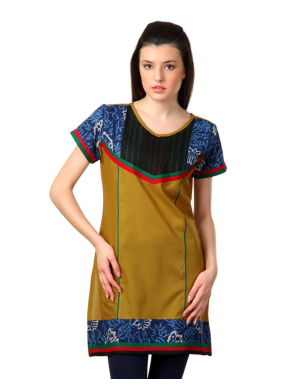

⬇------------------- изображение 40655.jpg -------------------⬇
Style Note


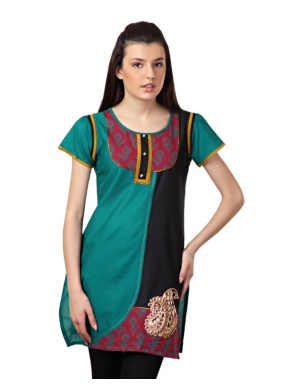

⬇------------------- изображение 40626.jpg -------------------⬇
Style Note


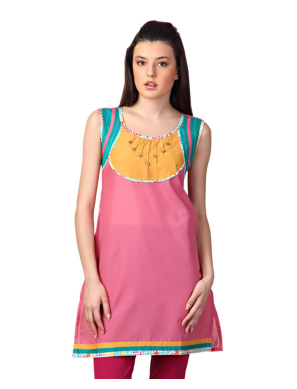

In [19]:
show_images (df_train [df_train['description'] == 'Style Note'][:3])

-- такие дубликаты удалим, т. к. описание бессмысленное, а картинки противоречивые.

In [20]:
df_train = df_train [df_train['description'] != 'Style Note']

⬇------------------- изображение 55946.jpg -------------------⬇
Chip-resistant and prevents yellowing of nails Fast drying and long wearing
Simple one stroke application


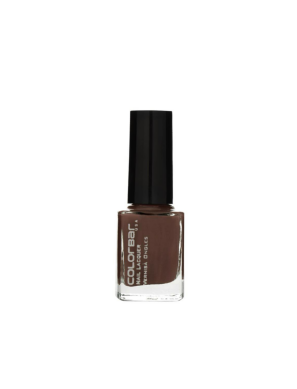

In [21]:
show_images (df_train [df_train['description'] == 'Chip-resistant and prevents yellowing of'
                 ' nails Fast drying and long wearing Simple one stroke application'][:3])

-- такие дубликаты оставим.

Посмотрим разрешения картинок:

In [22]:
def get_resolution (row):
    image_path = os.path.join (IMAGES_PATH, row['image'])
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except FileNotFoundError:
        print(f"Ошибка: Файл не найден по пути {image_path}")
    except Exception as e:
        print(f"Произошла ошибка при обработке изображения: {e}")    


df_train [['width', 'height']] = df_train.apply(get_resolution, axis=1, result_type='expand')

In [23]:
df_train['width'].value_counts()

width
1080    439
Name: count, dtype: int64

In [24]:
df_train['height'].value_counts()

height
1440    439
Name: count, dtype: int64

Все изображения имеют разрешение  1080х1440

Посмотрим на несколько случайных изображений и текстов, оценим их соответствие:

In [25]:
pd.options.display.max_colwidth = 10

⬇------------------- изображение 24523.jpg -------------------⬇
Composition Blue printed round neck kurta made of blended cotton fabric, has a
split neckline, three quarter sleeves, mirror and thread work on the yoke and a
vented hem  Fit Regular  Wash care Hand wash separately in cold water using a
mild detergent as colour may bleed Flat dry inside out in shade Warm iron  The
inspiration for this kurta from mother earth is the retro-esque fusion of ethnic
apparel and smart workwear. This piece epitomizes how fashion, vintage styling
and comfort unite to create the perfect Indian tunic. Mother Earth uses hand
processed fabrics including natural and Azo free dyes. Woven with slub yarns for
an authentic vintage feel. Those interested in colourblocking can wear this with
bright contrasting capris or pants. Others, who want to keep their look classic
and chic, can pair this with jeggings and embellished slippers.  Model
statistics The product is a size S on a model of height 5'8" and chest

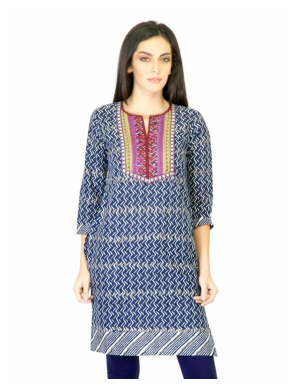

⬇------------------- изображение 42147.jpg -------------------⬇
Style Note This vintage style nike Sweet Classic Leather shoe is a perfect
fusion of street fashion and tennis glam. Designed for the tennis lover, these
shoes blend function and fashion effortlessly, to make you look fabulous on and
off the court.  Product Details White leather shoe with central lace-ups,
overlays, nike swoosh and stitched detailing Padded tongue and inner Tough
rubber midsole Durable rubber outsole with herringbone grooves  Material and
Care Leather Wipe surface with a clean, damp cloth Do not store in direct
sunlight


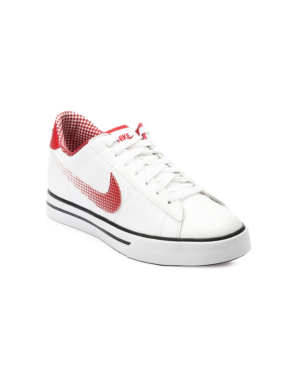

⬇------------------- изображение 26737.jpg -------------------⬇
Style Note Straight from the Sports lifestyle reebok collection of deodorants
comes this fabulous Reesport deodorant. This amazing fragrant sensation is for
men and comes in a cylindrical bottle Caution Flammable Keep away from sources
of ignition Keep away from children Do not use near fire, flame or heat Avoid
spraying near the eyes Quantity : 150 ml


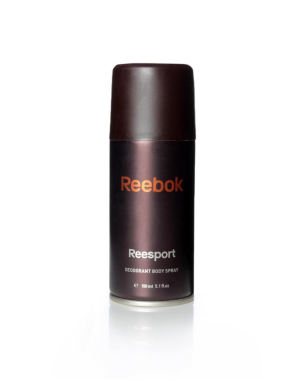

⬇------------------- изображение 57153.jpg -------------------⬇
Peach knit, cropped T-shirt, has a round neckline, short extended sleeves and a
graphic print with red beaded detail on the front


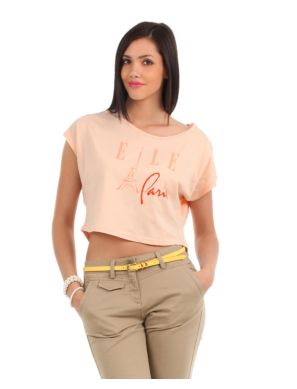

⬇------------------- изображение 40691.jpg -------------------⬇
Style Note The simple design of these numero uno shoes have an understated
elegance. The comfortable design takes you through the day in style. Team these
up with jeans and long sleeved grey or black tees for a simple, striking look.
Product Details  Square toe, black shoe with slip on styling Leather upper with
reinforced overlay at the heel collar Decorative stitching on the toe box Mildly
padded collar and tongue, tongue with elasticated gussets on the sides, padded
footbed TPU  outsole with a stacked heel and pattern grooves at the forefoot
region   Material and Care Leather Use branded leather conditioner and polish or
wax on leather parts Do not store in direct sunlight


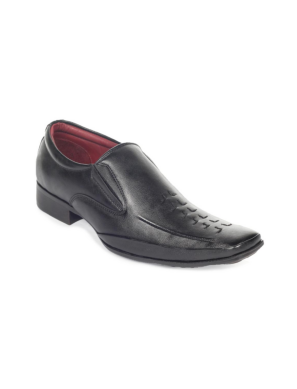

⬇------------------- изображение 13621.jpg -------------------⬇
Composition Grey shorts made of ComfortSoft 100% combed cotton, has light grey
and white panels with black piping on the sides, elasticated waistband covered
with a ComfortSoft fabric and a drawstring   Fit  Comfort   Wash care  Machine
wash warm with like colours Do not bleach Tumble dry low Warm iron  A stylish
and sporty short that can be worn on the beach, on a relaxed day at home or
during vacations, this product from hanes is created keeping your comfort in
mind. The luxurious ComfortSoft fabric not only retains its shape even after
repeated washes, but also offers superior comfort. And with the ComfortSoft
fabric covering the elasticated waistband, be assured of a pinch-free
comfortable fit, while you can further customise the fitting with the
drawstring. Wear this with Sports t-shirts or casual ones and revel in a
comfortable lifestyle.   Model statistics  The model wears size M in shorts,
with a length of 45 cm He

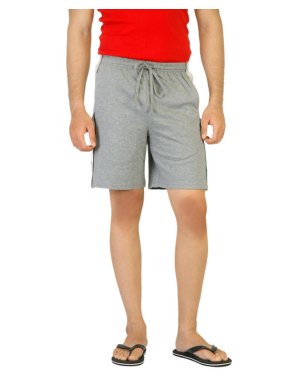

⬇------------------- изображение 56811.jpg -------------------⬇
White and pink floral printed woven tunic, has a mandarin collar with a split
neckline, three fourth sleeves with paneling on the cuffs, space tucks and
paneling on the mid arm, mirror work and embroidery on the yoke, and a vented
hem


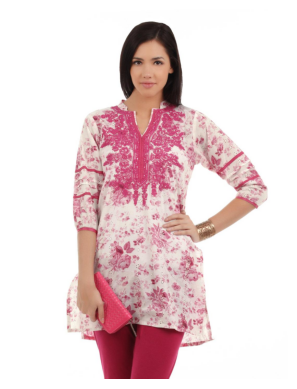

⬇------------------- изображение 44106.jpg -------------------⬇
Style Note hugo boss present an exclusive 'Element' gift set with these EDT for
men and a shower gel. This brand has perfected the craft of creating endlessly
stylish fragrances as this set will prove! Product Details hugo Element EDT for
men comes in a glass flacon Hugo Element shower gel for men comes in a plastic
tube Quantity Hugo Element EDT: 90 ml Hugo Element shower gel: 150 ml


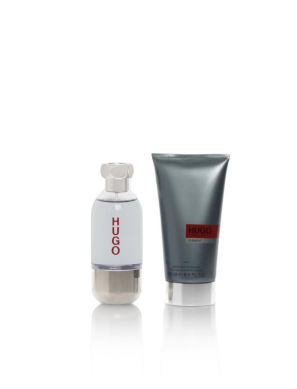

⬇------------------- изображение 22596.jpg -------------------⬇
Composition Red t-shirt made of 100% polyester, is engineered with Dri-Fit
technology, has a mock neck, short raglan sleeves and printed nike swoosh on the
left chest Fit Regular Wash care Machine wash cold with like colours Do not dry
clean or bleach Tumble dry low Warm iron Crafted from soft cotton-polyester
fabric and engineered with Dri-Fit technology, this t-shirt from nike offers
exemplary dry comfort, making it a great everyday choice for your healthy runs
and casual days. Team this printed tee with jeans and running shoes for a sporty
look. Add on a hooded sweatshirt for exemplary comfort during winters. Model
statistics The product is a size M on a model of height 6' and shoulders 18"


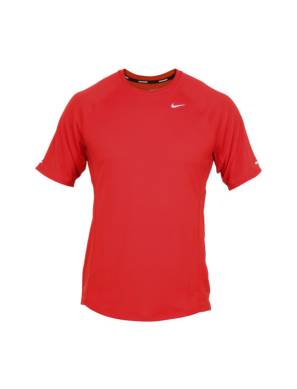

⬇------------------- изображение 17444.jpg -------------------⬇
Case style: Analogue watch, has a circular case and a stainless steel back Dial
style: Silver-toned dial Features: Has a chronographic display, a screw to reset
the time and two push-buttons to reset the features Strap style: Brown leather
strap, secured with a tang clasp Comes in a signature CASIO case


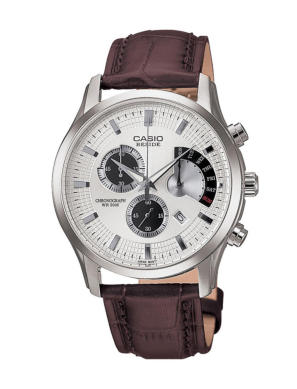

In [26]:
show_images (df_train.sample(10, random_state=RANDOM_STATE))

Описания данных 10 изображений являются корректными.

In [27]:
df_train.shape

(439, 4)

In [28]:
df_val.shape

(50, 2)

## Выводы по итогам EDA



- удалены образцы с пустыми или с незначищими описаниями (без букв)
- все изображения имеют разрешение  1080х1440
- всего изображения в тренировочном датасете осталось 38791, в валидационном - 4445
- описания выборочных 10 изображений являются корректными

## Подготовка датасета

Реализуем свой класс датасета, который будет подгружать картинки и соответствующие им текстовые описания.

In [ ]:
class CLIPDataset(Dataset):
    def __init__(self, df, processor, tokenizer, base_path):
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.base_path = base_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.base_path, row['image'])
        description = row['description']
        if 

        try:
            image = Image.open(image_path).convert("RGB")
            image_inputs = self.processor(images=image, return_tensors="pt")
            
            text_inputs = self.tokenizer(
                description, 
                padding="max_length", 
                truncation=True, 
                max_length=self.tokenizer.model_max_length, 
                return_tensors="pt"
            )

            # Удаляем размерность батча, добавленную процессором/токенайзером
            return {
                'pixel_values': image_inputs['pixel_values'].squeeze(),
                'input_ids': text_inputs['input_ids'].squeeze(),
                'attention_mask': text_inputs['attention_mask'].squeeze()
            }
        
        except FileNotFoundError:
            print(f"Файл не найден: {image_path}. Пропускаем.")
            return None
        except Exception as e:
            print(f"Ошибка при загрузке {image_path}: {e}. Пропускаем.")
            return None

def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

## Загрузка модели

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME)

train_dataset = CLIPDataset(df_train, processor, tokenizer, base_path=IMAGES_PATH)
val_dataset = CLIPDataset(df_val, processor, tokenizer, base_path=IMAGES_PATH)

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn
)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [39]:
summary(model, device=device)

Layer (type:depth-idx)                                       Param #
CLIPModel                                                    1
├─CLIPTextTransformer: 1-1                                   --
│    └─CLIPTextEmbeddings: 2-1                               --
│    │    └─Embedding: 3-1                                   25,296,896
│    │    └─Embedding: 3-2                                   39,424
│    └─CLIPEncoder: 2-2                                      --
│    │    └─ModuleList: 3-3                                  37,828,608
│    └─LayerNorm: 2-3                                        1,024
├─CLIPVisionTransformer: 1-2                                 --
│    └─CLIPVisionEmbeddings: 2-4                             768
│    │    └─Conv2d: 3-4                                      2,359,296
│    │    └─Embedding: 3-5                                   38,400
│    └─LayerNorm: 2-5                                        1,536
│    └─CLIPEncoder: 2-6                                      -

Прогоним через модель несколько примеров из датасета и посмотрите, какие получаются CLIP-скоры:

In [31]:
def calculate_clip_score(image_features, text_features):
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    logits_per_image = torch.matmul(image_features, text_features.t())
    return logits_per_image.diag().mean().item()

model.eval()
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    if sample_batch:
        sample_batch = {k: v.to(device) for k, v in sample_batch.items()}
        
        outputs = model(
            input_ids=sample_batch['input_ids'], 
            attention_mask=sample_batch['attention_mask'], 
            pixel_values=sample_batch['pixel_values'], 
            return_loss=True
        )
        
        image_features = outputs.image_embeds
        text_features = outputs.text_embeds
        initial_loss = outputs.loss.item()
        initial_score = calculate_clip_score(image_features, text_features)
        
        print(f"Начальная функция потерь (батч): {initial_loss:.4f}")
        print(f"Начальный CLIP Score (батч): {initial_score:.4f}")

Начальная функция потерь (батч): 0.0001
Начальный CLIP Score (батч): 0.3394


## Дообучение

In [35]:
def validate_epoch(model, val_loader, device):
    model.eval()
    total_clip_score = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Валидация"):
            if batch is None: continue
            
            batch = {k: v.to(device) for k, v in batch.items()}
            
            outputs = model(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask'], 
                pixel_values=batch['pixel_values'],
                return_loss=False # На валидации нам не нужна функция потерь
            )
            
            score = calculate_clip_score(outputs.image_embeds, outputs.text_embeds)
            total_clip_score += score
            num_batches += 1
            
    if num_batches == 0:
        return 0.0
        
    avg_clip_score = total_clip_score / num_batches
    return avg_clip_score

train_losses = []
train_scores = []
val_scores = []
best_val_score = -float('inf')

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    epoch_score = 0.0
    num_batches = 0
    
    tqdm_loader = tqdm(train_loader, desc=f"Эпоха {epoch+1}/{NUM_EPOCHS}")
    
    for batch in tqdm_loader:
        if batch is None: continue
        
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask'], 
            pixel_values=batch['pixel_values'], 
            return_loss=True
        )
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        score = calculate_clip_score(outputs.image_embeds, outputs.text_embeds)
        
        epoch_loss += loss.item()
        epoch_score += score
        num_batches += 1
        
        tqdm_loader.set_postfix(
            {
                'Train Loss': f'{epoch_loss/num_batches:.4f}', 
                'CLIP Score': f'{epoch_score/num_batches:.4f}'
            }
        )

    # --- Замер метрик эпохи ---
    avg_train_loss = epoch_loss / num_batches
    avg_train_score = epoch_score / num_batches
    train_losses.append(avg_train_loss)
    train_scores.append(avg_train_score)

    # --- Валидация ---
    avg_val_score = validate_epoch(model, val_loader, device)
    val_scores.append(avg_val_score)

    print(f"\n--- Эпоха {epoch+1} завершена ---")
    print(f"Средняя функция потерь (Train): {avg_train_loss:.4f}")
    print(f"Средний CLIP Score (Train): {avg_train_score:.4f}")
    print(f"Средний CLIP Score (Validation): {avg_val_score:.4f}")

    # --- Checkpoint ---
    if avg_val_score > best_val_score:
        best_val_score = avg_val_score
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"best_model_epoch_{epoch+1}_val_score_{avg_val_score:.4f}.pt")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint сохранен: {checkpoint_path}")

Валидация: 100%|██████████| 17/17 [00:12<00:00,  1.41it/s]



--- Эпоха 1 завершена ---
Средняя функция потерь (Train): 1.0713
Средний CLIP Score (Train): 0.0388
Средний CLIP Score (Validation): 0.0305
Checkpoint сохранен: clip_checkpoints\best_model_epoch_1_val_score_0.0305.pt


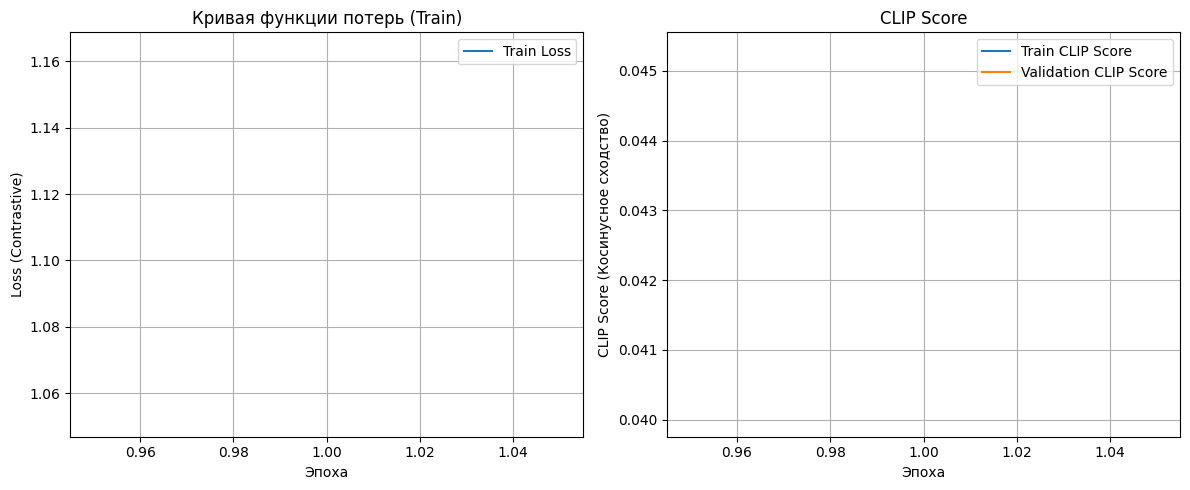

In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.title('Кривая функции потерь (Train)')
plt.xlabel('Эпоха')
plt.ylabel('Loss (Contrastive)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_scores, label='Train CLIP Score')
plt.plot(range(1, NUM_EPOCHS + 1), val_scores, label='Validation CLIP Score')
plt.title('CLIP Score')
plt.xlabel('Эпоха')
plt.ylabel('CLIP Score (Косинусное сходство)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

👷🚩[todo] описать результаты анализа данных

Освободим память, т. к. в задании далее треубется загрузить модель из чекпоинта:

In [ ]:
if not JUST_DEBUG_ON_CPU:
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    torch.cuda.ipc_collect()
    print(torch.cuda.memory_summary())
del model
del processor
del tokenizer

# Этап 2. Реализация системы поиска товаров

## Подготовка модели и данных

Загрузим чекпоинт дообученной модели:

In [40]:
checkpoint_files = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pt')]

In [43]:
last_checkpoint = sorted(checkpoint_files, reverse=True)[0] 
BEST_CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, last_checkpoint)
BEST_CHECKPOINT_PATH

'clip_checkpoints\\best_model_epoch_1_val_score_0.0453.pt'

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model_search = CLIPModel.from_pretrained(MODEL_NAME).to(device)
model_search.load_state_dict(torch.load(BEST_CHECKPOINT_PATH, map_location=device))
model_search.eval()
processor_search = CLIPProcessor.from_pretrained(MODEL_NAME)
tokenizer_search = CLIPTokenizer.from_pretrained(MODEL_NAME)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

Все пропуски description заполним пустой строкой:

In [53]:
df['description'] = df['description'].fillna('')

 Сохраним все векторные представления изображений:

In [ ]:
all_dataset = CLIPDataset(df, processor_search, tokenizer_search, base_path=IMAGES_PATH)
all_loader = DataLoader(
    all_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn
)
all_image_embeddings = []

In [ ]:
with torch.no_grad():
    for batch in tqdm(all_loader, desc="Кодирование изображений"):
        if batch is None:
            continue
            
        pixel_values = batch['pixel_values'].to(device)
        image_embeds = model_search.get_image_features(pixel_values)
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        all_image_embeddings.append(image_embeds.cpu())

all_image_embeddings_tensor = torch.cat(all_image_embeddings)
print(f"Общее количество закодированных векторов: {all_image_embeddings_tensor.shape[0]}")
print(f"Размерность векторов: {all_image_embeddings_tensor.shape[1]}")

# Сохраняем векторные представления и исходный DataFrame для поиска
df_indexed = df.copy()
df_indexed['embeddings'] = all_image_embeddings_tensor.tolist()

Кодирование изображений: 100%|██████████| 16/16 [00:53<00:00,  3.37s/it]

Общее количество закодированных векторов: 500
Размерность векторов: 512


,image,description,embeddings
0,3238.jpg,Round ...,[0.025...
1,43044.jpg,Style ...,[0.024...
2,54018.jpg,Teal ...,[0.029...
3,8141.jpg,Perfec...,[0.026...
4,22245.jpg,These ...,[0.023...


In [58]:
pd.options.display.max_colwidth = 500

In [60]:
df_indexed.head(3)

,image,description,embeddings
0,3238.jpg,"Round toed, black sports shoes with red accents, low top styling and central lace-ups Leather upper with stitched detail, overlay, Formstrip and Ducati branding on the sides and reinforced heel collar with branding Soft tongue and inner, branding on the tongue Cushioned footbed with branding at the heel Printed detail at the midsole Textured rubber outsole with patterned grooves and branding Warranty: 3 months against manufacturing defects only","[0.02540735900402069, -0.01073684636503458, 0.00381865375675261, 0.014186384156346321, -0.005004956852644682, 0.0022878285963088274, -0.021400252357125282, 0.03416012227535248, 0.013521655462682247, 0.001573045738041401, -0.018212750554084778, 0.0007544537074863911, 0.014969981275498867, 0.014808034524321556, 0.0064011733047664165, -0.005376105196774006, -0.09019360691308975, -0.048233117908239365, -0.01851213164627552, 0.039727285504341125, 0.01825670711696148, 0.03698526322841644, 0.005171..."
1,43044.jpg,"Style Note Built with the breathability and zero-distraction Fit that athletes demand, these boardshorts come in a body-friendly design. These high-performance shorts are great for a day out at the beach and are designed to aid your aquatic performance. Team them with T-shirts and flip flops. Product Details Charcoal grey boardshorts, with a velcro closure and a cord tie detail, zipped pocket and a nike swoosh on left leg Material and Care 100% polyester Machine wash separately in cold water...","[0.02451397106051445, -0.011781112290918827, 0.0032369443215429783, 0.012313726358115673, -0.003317163558676839, 0.0030932624358683825, -0.0220116525888443, 0.03394528478384018, 0.01610470376908779, 0.0025824757758527994, -0.018207324668765068, 0.003036465495824814, 0.015040213242173195, 0.016476234421133995, 0.007461505942046642, -0.006602463778108358, -0.0892024114727974, -0.04512568935751915, -0.017551366239786148, 0.03976038098335266, 0.014036457985639572, 0.03992580249905586, 0.00712931..."
2,54018.jpg,"Teal handbag that has stitch detailing with a pleated and panel design on the front One main zipped compartment that has an inner zipped pocket and an organiser sleeve One zipped pocket on the front One long, adjustable strap woven through metallic loops for carrying ease and style One zipped pocket at the back","[0.029003819450736046, -0.011287761852145195, 0.002744955476373434, 0.015063740313053131, -0.006077069789171219, 0.0061550745740532875, -0.020546240732073784, 0.03669847548007965, 0.011749424040317535, -0.0024153655394911766, -0.016777394339442253, -0.0008430825546383858, 0.018735555931925774, 0.015693722292780876, 0.007860117591917515, -0.007914995774626732, -0.08822839707136154, -0.050188589841127396, -0.016374336555600166, 0.04213322326540947, 0.018677843734622, 0.0367765948176384, 0.0043..."


## Функция поиска товаров

In [77]:
def show_results(results_df, query):
    pd.options.display.max_colwidth = 1000
    
    print("-" * 100)
    print(f"Текстовый запрос: '{query}'")
    print(f"Найдено {len(results_df)} наиболее релевантных товаров.")
    
    for _, row in results_df.iterrows():
        image_path = os.path.join(IMAGES_PATH, row['image'])
        
        try:
            image = Image.open(image_path)
            
            print(f"⬇------------------- Товар: {row['image']} | CLIP Score: {row['Similarity Score']:.4f} -------------------⬇")
            
            # Используем textwrap для переноса описания
            wrapped_description = textwrap.fill(row['description'], width=80)
            print(wrapped_description)
            
            plt.imshow(image)
            plt.axis('off')
            plt.show()
        
        except FileNotFoundError:
            print(f"Ошибка: Файл не найден по пути {image_path}. Пропускаем отображение.")
        except Exception as e:
            print(f"Произошла ошибка при обработке изображения: {e}. Пропускаем отображение.")

In [78]:
def search_products(
    model: CLIPModel, 
    tokenizer: CLIPTokenizer,
    df_indexed: pd.DataFrame, 
    query: str, 
    k: int = 5, 
    device: str = 'cpu',
    ):

    with torch.no_grad():
        text_inputs = tokenizer(
            query, 
            padding="max_length", 
            truncation=True, 
            max_length=tokenizer.model_max_length, 
            return_tensors="pt"
        ).to(device)
        
        text_embeds = model.get_text_features(
            input_ids=text_inputs['input_ids'], 
            attention_mask=text_inputs['attention_mask']
        )
        
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds.cpu()

    image_embeddings = torch.tensor(df_indexed['embeddings'].tolist())
    
    similarity_scores = torch.matmul(text_embeds, image_embeddings.T).squeeze(0)

    top_k_values, top_k_indices = torch.topk(similarity_scores, k)

    results_df = df_indexed.iloc[top_k_indices.tolist()].copy()
    results_df['Similarity Score'] = top_k_values.tolist()
    
    show_results (results_df.drop(columns=['embeddings']).reset_index(drop=True), query)

## Тестирование

----------------------------------------------------------------------------------------------------
Текстовый запрос: 'red skirt'
Найдено 5 наиболее релевантных товаров.
⬇------------------- Товар: 4752.jpg | CLIP Score: 0.0515 -------------------⬇
Red, polo t-shirt made of 100% cotton, with ribbed collar, embroidered logo on
left chest and slanting subliminal graphic print along the lower half


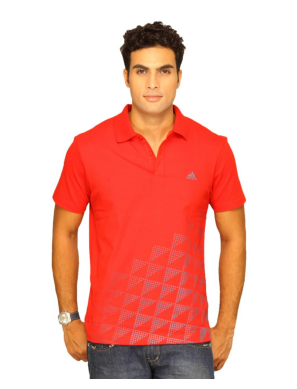

⬇------------------- Товар: 30735.jpg | CLIP Score: 0.0510 -------------------⬇
Composition Beige churidar made of cotton fabric, has waistband with drawstrings
and tapered legs  Fit Regular  Wash care Hand wash separately in cold water
using mild detergent Dry in shade Do not soak  This churidar from fabindia is
designed to provide absolute comfort and perfect fit. Team it with a kurta and
ethnic sandals and you're all set to seize the day with a fab look.  Model
statistics The product is a size M on a model of height 6' and waist 32& rdquo


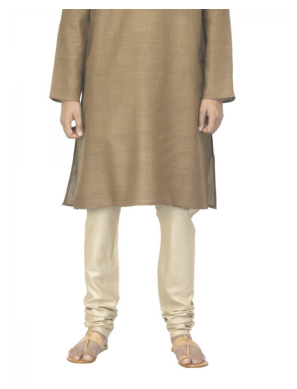

⬇------------------- Товар: 51672.jpg | CLIP Score: 0.0503 -------------------⬇
Lens colour: Brown shaded Frame colour: Silver and maroon Frame type: Metal,
aviator style Branding at the sides  soft nose-pads The glasses come in a case


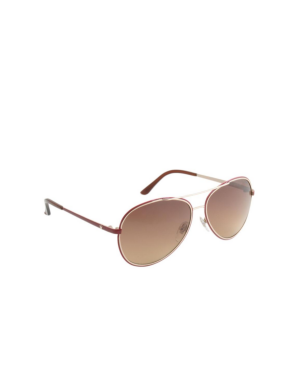

⬇------------------- Товар: 13572.jpg | CLIP Score: 0.0501 -------------------⬇
Composition Red sleeveless vest made of ComfortFit 100% combed cotton ribbed
fabric, has a round ribbed neck and racer back with a brand badge at the back
neck   Fit  Comfort   Wash care  Machine wash warm with like colours Do not
bleach Tumble dry low Warm iron  Revel in the luxurious comfort of a combed
cotton fabric in this vest from hanes. Engineered with ComfortFit technology,
this vest made of ribbed combed cotton fabric will contour your body perfectly,
stretch to your ease and retain its shape wash after wash. The athletic neckline
and stylish shoulder straps offer a flattering fit. And what's even better is
that this vest comes with a printed brand label on the inner neck - so bid
goodbye to those scratchy labels and welcome comfort at its best!  Model
statistics  The model wears size M in vests Height: 6', Shoulders: 19"


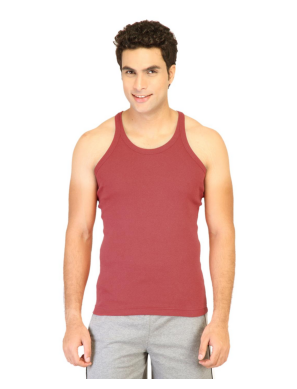

⬇------------------- Товар: 30618.jpg | CLIP Score: 0.0497 -------------------⬇
Composition Red round neck T-shirt for men made of 100% cotton, has short
sleeves and graphic print on the left chest   Fit  Slim   Wash  care  Machine
wash cold with like colours Do not dry clean or bleach Tumble dry low Warm iron;
do not iron on decorations  A summer staple from nike for the urban male, this
piece is sure to become an off-duty favourite in your sport fashion collection.
Crafted for sport and fashioned to look great, nike gets it right with this
versatile piece. Style this with tonal sport or casual shoes and track pants or
your favourite jeans.


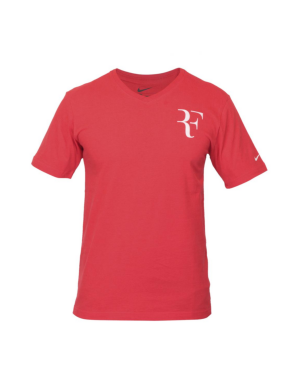

In [79]:
search_products(
    model=model_search, 
    tokenizer=tokenizer_search,
    df_indexed=df_indexed, 
    query="red skirt", 
    k=5, 
    device=device,
)

----------------------------------------------------------------------------------------------------
Текстовый запрос: 'blue sunglasses'
Найдено 5 наиболее релевантных товаров.
⬇------------------- Товар: 51672.jpg | CLIP Score: 0.0531 -------------------⬇
Lens colour: Brown shaded Frame colour: Silver and maroon Frame type: Metal,
aviator style Branding at the sides  soft nose-pads The glasses come in a case


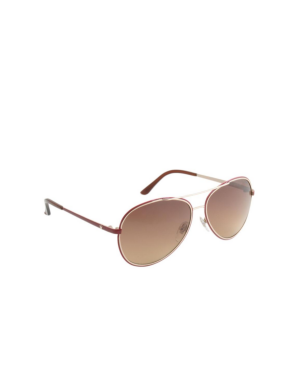

⬇------------------- Товар: 46935.jpg | CLIP Score: 0.0531 -------------------⬇
York EXZOTYK Pour Homme eau de toilette Enriched with notes of musk and burt
Comes in a glass bottle


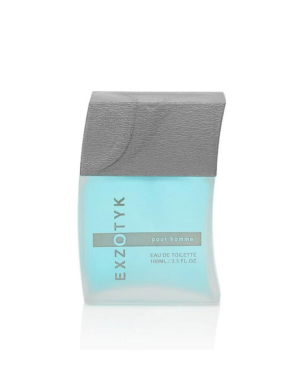

⬇------------------- Товар: 14438.jpg | CLIP Score: 0.0529 -------------------⬇
Revel in the comfort of pure leather and look stylish in ease with this pair of
slippers from enroute. Pamper your feet with the stylish flower embellishment
and enhance your style quotient by pairing it with any kind of casual and ethnic
clothing . This pair comes with a shoe bag to help you carry it around in ease.
Upper Leather T-straps with a toe separator, stitch to the midfoot sides and has
a flowerlet on the centre Movable strap on the backfoot with a buckle to
customise the Fit Leather footbed with cushioning under the heel and
perforations on the forefoot to ensure sweat-free comfort Outsole Durable rubber
outsole textured on the forefoot and heel for absolute grip and traction Sandal
care Wipe the leather surface with a dry, clean cloth to remove dust and dirt Do
not store in direct sunlight


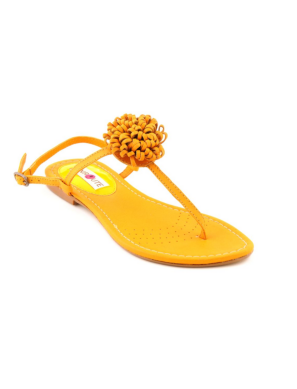

⬇------------------- Товар: 52860.jpg | CLIP Score: 0.0527 -------------------⬇
A triangular shaped dangler in red with green and white floral patterns Has a
fish hook closure


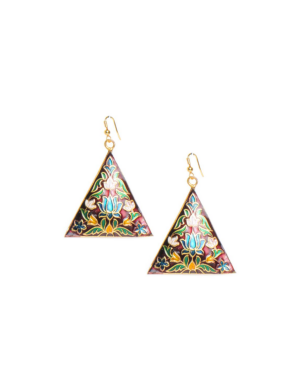

⬇------------------- Товар: 14928.jpg | CLIP Score: 0.0527 -------------------⬇
Composition Grey sweatshirt made of 100% cotton, that has a round ribbed
neckline, full length arms with ribbed cuffs, and print on the chest with felt
detailing Fitting Slim Wash care Machine wash inside out at 40 degrees with like
colours Wash inside out with like colours Do not bleach Dry in shade Do not iron
on print Be proud of your paunch - years of hard work has gone into building
that! On the hindsight, just issue a warning to you friends that there is a bump
ahead! Keep the chill at bay and look great at the same time in this sweatshirt.
Team this funky sweatshirt from mr.men with a pair of jeans and canvas shoes.
Model statistics The model wears size M in sweatshirts Height-6.1', Shoulders- "


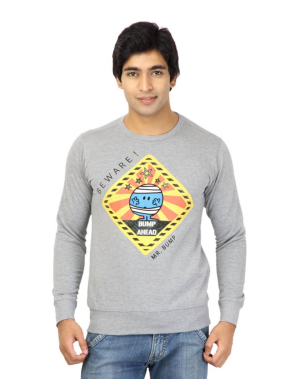

In [80]:
search_products(
    model=model_search, 
    tokenizer=tokenizer_search,
    df_indexed=df_indexed, 
    query="blue sunglasses", 
    k=5, 
    device=device,
)

----------------------------------------------------------------------------------------------------
Текстовый запрос: 'mickey mouse'
Найдено 5 наиболее релевантных товаров.
⬇------------------- Товар: 52860.jpg | CLIP Score: 0.0662 -------------------⬇
A triangular shaped dangler in red with green and white floral patterns Has a
fish hook closure


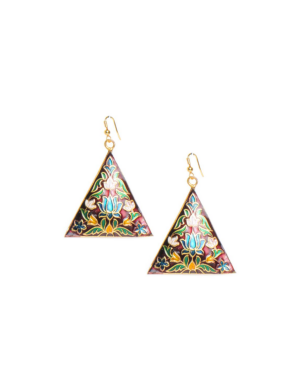

⬇------------------- Товар: 10564.jpg | CLIP Score: 0.0655 -------------------⬇
Composition White round neck t-shirt made of 100% cotton, with short sleeves,
brand badge on left hem, green collar and sleeve hems, has printed brand name on
the chest and Jumping cat on the chest and back neck   Fitting  Regular   Wash
care  Machine wash separately in cold water using a mild detergent Do not bleach
Avoid soaking Line dry inside out in shade Warm iron only Do not iron directly
on print/embroidery  Flaunt your brand statement in style with this white ringer
t-shirt from puma. The energetic Jumping Cat on the chest exudes fiery vibes,
while the pure cotton fabric keeps you fresh and comfortable all day long. Team
this with sportswear when on a fitness drive, and with jeans and black leather
sandals for a cool, casual look.   Model statistics  The model wears size M in
t-shirts Height-6.1', Shoulders-18"


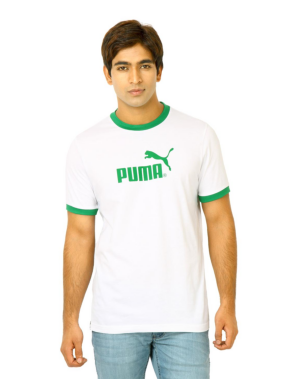

⬇------------------- Товар: 27455.jpg | CLIP Score: 0.0652 -------------------⬇
Style Note jockey bras offer the best comfort and support for any occasion. This
is one brand you can rely on to give you the comfort you need without letting
you down in the style stakes. From Sports bras to glamourous evening-wear
options, jockey bras make sure you get the look and support you need, whatever
your shape or requirements. Product Details Semi coverage moulded bra with soft
seamless cups Soft tip underwire and double layered cups for a complete and
excellent lift Soft, adjustable straps that rest comfortably on your shoulders
leaving no marks on your skin Material and Care Cotton/elastane Machine wash
delicate at 40 degrees with like colours Do not bleach, iron or dry clean Flat
dry in shade  Owing to intimate nature of this product it is eligible for self-
ship return only (no pick-up facility)


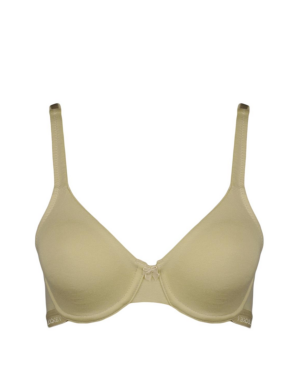

⬇------------------- Товар: 17025.jpg | CLIP Score: 0.0651 -------------------⬇
If you expect your footwear to be extremely comfortable coupled with great
looks, you've come to the right place!  These flip flops from gas pamper your
feet all day long as you go about doing your daily chores with even greater
enthusiasm. This close-to-barefoot footwear can be paired with just about any
kind of casual wear for a fab look.  Upper  Synthetic upper for  maximum
durability, comfort and style Thong straps to hold the foot in place Brand name
on the footbed and strap  Midsole  Synthetic midsole with stitch detailing for
enhanced durability and style  Outsole PU outsole with elevated horizontal
grooves  for absolute grip and traction  shoe Care  Rub surface with clean, damp
cloth to remove dust


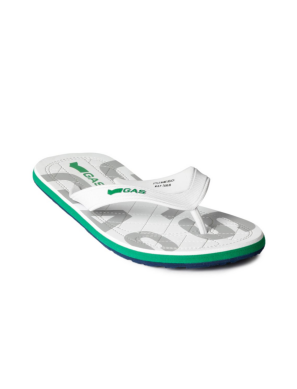

⬇------------------- Товар: 30735.jpg | CLIP Score: 0.0649 -------------------⬇
Composition Beige churidar made of cotton fabric, has waistband with drawstrings
and tapered legs  Fit Regular  Wash care Hand wash separately in cold water
using mild detergent Dry in shade Do not soak  This churidar from fabindia is
designed to provide absolute comfort and perfect fit. Team it with a kurta and
ethnic sandals and you're all set to seize the day with a fab look.  Model
statistics The product is a size M on a model of height 6' and waist 32& rdquo


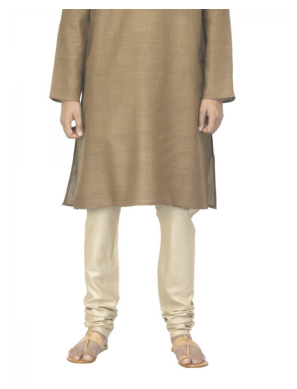

In [81]:
search_products(
    model=model_search, 
    tokenizer=tokenizer_search,
    df_indexed=df_indexed, 
    query="mickey mouse", 
    k=5, 
    device=device,
)

# Выводы

